<a href="https://colab.research.google.com/github/Pravallika-Myneni/Data_science_pipeline/blob/main/pm_milestone_clustering_chicago_gmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/crime_merged.csv', index_col = [0])
df.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Other Asian,Native Hawaiian and Other Pacific Islander,Native Hawaiian,Chamorro,Samoan,Other Pacific Islander,Some other race,ZipCode,Median_Income,Mean_Income
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,96,36,9,0,10,17,2103,60644,28033,44694
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,249,0,0,0,0,0,150,60661,125365,148266


In [7]:
df['Date'].value_counts()

01/01/2016 12:01:00 AM    132
01/01/2017 12:01:00 AM     99
01/01/2018 12:01:00 AM     97
01/01/2017 12:00:00 AM     96
05/31/2020 04:00:00 PM     90
                         ... 
10/16/2016 11:44:00 PM      1
03/29/2020 11:01:00 PM      1
05/14/2015 12:24:00 PM      1
03/29/2020 04:08:00 PM      1
09/09/2022 12:13:00 PM      1
Name: Date, Length: 880517, dtype: int64

In [11]:
df['Community Area'].nunique()

77

In [12]:
community_value_counts = df['Community Area'].value_counts()
community_value_counts

25.0    111192
8.0      79031
28.0     63918
32.0     63788
43.0     63624
         ...  
55.0      4385
74.0      4160
12.0      3841
47.0      2785
9.0       2006
Name: Community Area, Length: 77, dtype: int64

In [13]:
df['ID'].nunique(), df.shape

(1884111, (1884111, 58))

In [14]:
df.groupby(['Community Area', 'Date']).count()['ID'].groupby(level = 0).count()

Community Area
1.0     27062
2.0     24106
3.0     24795
4.0     13590
5.0      9274
        ...  
73.0    21926
74.0     4063
75.0    14139
76.0    11465
77.0    18059
Name: ID, Length: 77, dtype: int64

In [15]:
df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'clean block', 'zipcode', 'Unnamed: 0.1', 'Zipcode',
       'SEX AND AGE', 'Total population', 'Male', 'Female',
       'Total population.1', 'One race', 'Two or more races', 'One race.1',
       'White', 'Black or African American',
       'American Indian and Alaska Native', 'Cherokee tribal grouping',
       'Chippewa tribal grouping', 'Navajo tribal grouping',
       'Sioux tribal grouping', 'Asian', 'Asian Indian', 'Chinese', 'Filipino',
       'Japanese', 'Korean', 'Vietnamese', 'Other Asian',
       'Native Hawaiian and Other Pacific Islander', 'Native Hawaiian',
       'Chamorro', 'Samoan', 'Other Pacific Islander', 'Some other race',
       'ZipCode', 'Median_Income', 'Mean_I

In [17]:
df_ = df[[ 'Latitude', 'Longitude', 'ID', 'Case Number' , 'Date', 'Block', 'IUCR', 'Primary Type', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'Zipcode', 'Median_Income', 'Mean_Income']].rename(columns = {'Date' : 'DateTime'})
df_['DateTime'] = pd.to_datetime(df_['DateTime'])
df_['Date'] = df_['DateTime'].dt.date
df_ = df_.rename(columns =  {col : col.replace(' ', '_') for col in df.columns})
df_['week'] = df_['DateTime'].dt.week
df_['day'] = df_['DateTime'].dt.day
df_['month'] = df_['DateTime'].dt.month
df_.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


,Latitude,Longitude,ID,Case_Number,DateTime,Block,IUCR,Primary_Type,Arrest,Domestic,...,Ward,Community_Area,FBI_Code,Zipcode,Median_Income,Mean_Income,Date,week,day,month
0,41.815117,-87.6700,10224738,HY411648,2015-09-05 13:30:00,043XX S WOOD ST,0486,BATTERY,False,True,...,12.0,61.0,08B,60644,28033,44694,2015-09-05,36,5,9
1,41.895080,-87.7654,10224739,HY411615,2015-09-04 11:30:00,008XX N CENTRAL AVE,0870,THEFT,False,False,...,29.0,25.0,06,60661,125365,148266,2015-09-04,36,4,9


In [18]:
pd.date_range(start="2015-01-01", end="2022-09-23").difference(df_.Date)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

May be before clustering, we can rank the ofns_Desc and use that as one more attribute for clustering..

we can use other attributes as well here

# Clustering into high threat - medium threat and low threat zones

In [27]:
clustering_df = df_.copy()[['Community_Area', 'ID', 'Arrest', 'Median_Income', 'Mean_Income']]
total = clustering_df.groupby(['Community_Area']).agg({ 'ID' : 'count', 'Median_Income' : 'mean', 'Mean_Income' : 'mean', 'Arrest' : 'sum'}).rename(columns = {'ID' : 'Total_incidents'})
#arrest_wise = clustering_df.groupby(['Community_Area', 'Arrest']).count()['ID'].to_frame().reset_index()
#arrest_true = arrest_wise[arrest_wise['Arrest']== True].drop(columns = ['Arrest']).rename(columns = {'ID': 'Arrested_true'}).set_index('Community_Area')
#arrest_false = arrest_wise[arrest_wise['Arrest']== False].drop(columns = ['Arrest']).rename(columns = {'ID': 'Arrested_false'}).set_index('Community_Area')

crime_rate = total.copy()#.merge(arrest_false,left_index=True, right_index=True, how='inner')
#crime_rate = crime_rate.merge(arrest_true,left_index=True, right_index=True, how='inner')
crime_rate['arrest_rate'] = crime_rate['Arrest']/crime_rate['Total_incidents']
crime_rate.head(2)

clustering_df_ = crime_rate.copy().drop(columns = ['Total_incidents', 'Arrest'])

In [28]:
clustering_df_.describe()

,Median_Income,Mean_Income,arrest_rate
count,77.000000,77.000000,77.000000
mean,53689.313792,78249.856461,0.168177
std,21281.568599,31642.430974,0.058626
min,29521.269442,45816.079455,0.077063
25%,37513.814663,56089.069555,0.124316
50%,50233.573169,70909.137867,0.163951
75%,60737.377359,89744.782747,0.187678
max,154970.682448,239173.042923,0.390888


In [29]:
clustering_df_.head(2)

,Median_Income,Mean_Income,arrest_rate
Community_Area,,,
1.0,54592.21032,76435.966637,0.163951
2.0,41813.91285,63755.237821,0.122120


Is there a point to do this.. convert to str then encode it?? For now, assuming no

In [30]:
"""from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

clustering_df_['Zipcode'] = le.fit_transform(clustering_df_['Zipcode'])

clustering_df_.head(2)"""

"from sklearn.preprocessing import LabelEncoder\n\nle = LabelEncoder()\n\nclustering_df_['Zipcode'] = le.fit_transform(clustering_df_['Zipcode'])\n\nclustering_df_.head(2)"

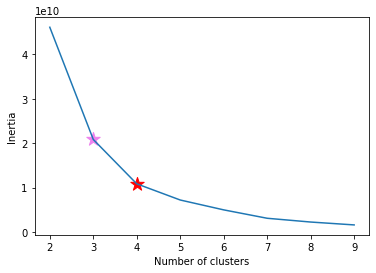

In [31]:
from sklearn.cluster import KMeans
X = np.array(clustering_df_)
inertias = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, init = "k-means++")
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
plt.plot(range(2,10), inertias)
plt.scatter(3,inertias[1], s = 200, c = 'violet', marker='*')
plt.scatter(4,inertias[2], s = 200, c = 'red', marker='*')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [32]:
##It gives an idea of how well the objects are classified taking that number of clusters
from sklearn.metrics import silhouette_score
for n_clusters in range(2,10):
    clusterer = KMeans(n_clusters=n_clusters, init = "k-means++")
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score (X, preds, metric='euclidean', n_jobs=-1)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.6244570032413831)
For n_clusters = 3, silhouette score is 0.589971843354852)
For n_clusters = 4, silhouette score is 0.5577626482946033)
For n_clusters = 5, silhouette score is 0.5561058951582118)
For n_clusters = 6, silhouette score is 0.5325580821008696)
For n_clusters = 7, silhouette score is 0.5417449828432708)
For n_clusters = 8, silhouette score is 0.48707385747373894)
For n_clusters = 9, silhouette score is 0.4874559225355205)


Silhouetee score is takiing ages to calculate.. try again later?

In [33]:
kmeans = KMeans(n_clusters=3, init = "k-means++")
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
pred = y_kmeans
kmeans = clustering_df_.copy()
kmeans['Label'] = pred
#kmeans = kmeans.reset_index() 

In [34]:
kmeans.shape

(77, 4)

In [35]:
pred.shape

(77,)

In [36]:
kmeans.head(5)

,Median_Income,Mean_Income,arrest_rate,Label
Community_Area,,,,
1.0,54592.210320,76435.966637,0.163951,1
2.0,41813.912850,63755.237821,0.122120,1
3.0,62367.492937,86387.481583,0.170394,0
4.0,43744.082972,67919.082546,0.124316,1
5.0,39964.254468,62946.580416,0.099801,1


In [37]:
kmeans[kmeans['Label'] ==0].describe()

,Median_Income,Mean_Income,arrest_rate,Label
count,24.000000,24.000000,24.000000,24.0
mean,70419.905384,102358.080167,0.198102,0.0
std,11467.757872,17329.477630,0.068296,0.0
min,55438.418993,81304.817335,0.077380,0.0
25%,60580.848299,89256.950194,0.156179,0.0
50%,70023.642657,97299.040375,0.182267,0.0
75%,77541.165781,111566.015502,0.230386,0.0
max,100127.402297,143016.459104,0.390888,0.0


In [38]:
kmeans[kmeans['Label'] == 1].describe()

,Median_Income,Mean_Income,arrest_rate,Label
count,51.000000,51.000000,51.000000,51.0
mean,42485.899912,61767.209198,0.154029,1.0
std,8146.950373,10263.017801,0.049438,0.0
min,29521.269442,45816.079455,0.077063,1.0
25%,35787.793118,52115.734367,0.121132,1.0
50%,41811.475651,61463.113220,0.146040,1.0
75%,50118.846896,70791.382969,0.183269,1.0
max,57971.952603,80509.239660,0.322938,1.0


In [39]:
kmeans[kmeans['Label'] == 2 ].describe()

,Median_Income,Mean_Income,arrest_rate,Label
count,2.000000,2.000000,2.000000,2.0
mean,138609.268613,209258.677192,0.169821,2.0
std,23138.533345,42305.301728,0.003957,0.0
min,122247.854779,179344.311460,0.167023,2.0
25%,130428.561696,194301.494326,0.168422,2.0
50%,138609.268613,209258.677192,0.169821,2.0
75%,146789.975531,224215.860058,0.171220,2.0
max,154970.682448,239173.042923,0.172619,2.0


Label which is high threat .... low threat.. based on means may be?

In [41]:
all(kmeans.groupby(['Community_Area'])['Label'].nunique()==1)

True

In [42]:
Community_Area_mapping_kmeans = { row['Community_Area']: row['Label']  for i,row in kmeans.reset_index().iterrows()}

## After clustering

[10020, 10115, 10199, 10311, 11359, 11371, 11425, 11430]  -- data is missing for these zip codes

In [45]:
mapping_ = df_.groupby(['Community_Area'])['Latitude', 'Longitude'].agg('min').reset_index()
mapping_kmeans = mapping_.copy()
mapping_kmeans["Label"] = mapping_kmeans['Community_Area'].apply(lambda x: Community_Area_mapping_kmeans[x])
mapping_kmeans.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Community_Area,Latitude,Longitude,Label
0,1.0,41.757067,-87.684558,1.0
1,2.0,41.865529,-87.710185,1.0
2,3.0,41.875155,-87.674394,0.0
3,4.0,41.885702,-87.705701,1.0
4,5.0,41.932245,-87.695130,1.0


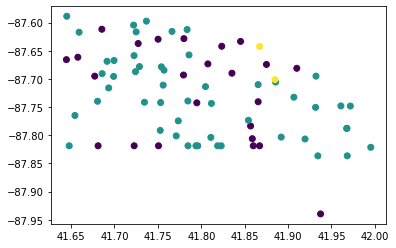

In [47]:
plt.scatter(mapping_kmeans['Latitude'], mapping_kmeans['Longitude'], c = mapping_kmeans['Label'])

## Gaussian Mixture Models

In [48]:
from sklearn.mixture import GaussianMixture

# define the model
gm = GaussianMixture(n_components=3)
# fit model and predict clusters
yhat = gm.fit_predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
plt.figure(figsize=(15,15))
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = np.where(yhat == cluster)
  	# create scatter of these samples
	#plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot

<Figure size 1080x1080 with 0 Axes>

In [49]:
gmm_df = clustering_df_.copy()
gmm_df['Label'] = yhat
gmm_df.head(3)

,Median_Income,Mean_Income,arrest_rate,Label
Community_Area,,,,
1.0,54592.210320,76435.966637,0.163951,0
2.0,41813.912850,63755.237821,0.122120,0
3.0,62367.492937,86387.481583,0.170394,1


In [50]:
gmm_df[gmm_df['Label'] == 0].describe()

,Median_Income,Mean_Income,arrest_rate,Label
count,48.000000,48.000000,48.000000,48.0
mean,42283.831027,61024.236712,0.147251,0.0
std,8561.775612,10166.794871,0.041166,0.0
min,29521.269442,45816.079455,0.077063,0.0
25%,35473.181411,51676.839906,0.118953,0.0
50%,40873.377559,59420.844242,0.136747,0.0
75%,49001.641646,69378.537736,0.181635,0.0
max,60737.377359,83914.541622,0.242224,0.0


In [51]:
gmm_df[gmm_df['Label'] == 1].describe()

,Median_Income,Mean_Income,arrest_rate,Label
count,27.000000,27.000000,27.000000,27.0
mean,67675.360573,99168.823370,0.205256,1.0
std,13143.844207,18669.293138,0.068893,0.0
min,44267.991784,70909.137867,0.077380,1.0
25%,57807.055986,85780.256308,0.159913,1.0
50%,67524.938863,95478.883747,0.198257,1.0
75%,76573.438940,110852.502412,0.248187,1.0
max,100127.402297,143016.459104,0.390888,1.0


In [52]:
gmm_df[gmm_df['Label'] == 2].describe()

,Median_Income,Mean_Income,arrest_rate,Label
count,2.000000,2.000000,2.000000,2.0
mean,138609.268613,209258.677192,0.169821,2.0
std,23138.533345,42305.301728,0.003957,0.0
min,122247.854779,179344.311460,0.167023,2.0
25%,130428.561696,194301.494326,0.168422,2.0
50%,138609.268613,209258.677192,0.169821,2.0
75%,146789.975531,224215.860058,0.171220,2.0
max,154970.682448,239173.042923,0.172619,2.0


In [54]:
Community_Area_mapping_gmm = { row['Community_Area']: row['Label']  for i,row in gmm_df.reset_index().iterrows()}

In [55]:
mapping_gmm = mapping_.copy()
mapping_gmm["Label"] = mapping_gmm['Community_Area'].apply(lambda x: Community_Area_mapping_gmm[x])
mapping_gmm.head()

,Community_Area,Latitude,Longitude,Label
0,1.0,41.757067,-87.684558,0.0
1,2.0,41.865529,-87.710185,0.0
2,3.0,41.875155,-87.674394,1.0
3,4.0,41.885702,-87.705701,0.0
4,5.0,41.932245,-87.695130,0.0


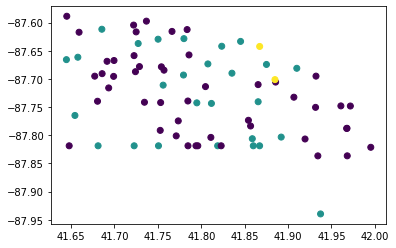

In [57]:
plt.scatter(mapping_gmm['Latitude'], mapping_gmm['Longitude'], c = mapping_gmm['Label'])

In [58]:
sum(mapping_gmm['Label'] == mapping_kmeans['Label']), sum(mapping_gmm['Label'] != mapping_kmeans['Label'])

(9, 68)

In [59]:
clustering_df_.iloc[0]

Median_Income    54592.210320
Mean_Income      76435.966637
arrest_rate          0.163951
Name: 1.0, dtype: float64

In [60]:
X[0]

array([5.45922103e+04, 7.64359666e+04, 1.63951228e-01])

In [61]:
gm.predict_proba([np.array([20000, 1000, 10000])])

array([[0., 1., 0.]])